In [1]:
import numpy as np
import pandas as pd
import random
import operator
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Train and Test Result with 1-Year Test (After the crisis)

In [2]:
# Load Data
train_0_rona_nc = pd.read_csv("resu/rona/no_cost/train_0_nc.csv", index_col="Episode")
train_1_rona_nc = pd.read_csv("resu/rona/no_cost/train_1_nc.csv", index_col="Episode")
train_2_rona_nc = pd.read_csv("resu/rona/no_cost/train_2_nc.csv", index_col="Episode")
train_3_rona_nc = pd.read_csv("resu/rona/no_cost/train_3_nc.csv", index_col="Episode")

test_0_rona_nc = pd.read_csv("resu/rona/no_cost/test_0_nc.csv", index_col="Date")
test_1_rona_nc = pd.read_csv("resu/rona/no_cost/test_1_nc.csv", index_col="Date")
test_2_rona_nc = pd.read_csv("resu/rona/no_cost/test_2_nc.csv", index_col="Date")
test_3_rona_nc = pd.read_csv("resu/rona/no_cost/test_3_nc.csv", index_col="Date")

# Prepare Data for in-sample and out-of-sample performance
train_res_rona_nc = [train_0_rona_nc[["Market Ep NAV", "Agent Ep NAV"]], train_1_rona_nc[["Agent Ep NAV"]],
                     train_2_rona_nc[["Agent Ep NAV"]], train_3_rona_nc[["Agent Ep NAV"]]]
train_res_rona_nc = pd.concat(train_res_rona_nc, axis=1)
train_res_rona_nc.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

test_res_rona_nc = pd.merge(test_0_rona_nc.reset_index()[["Date", "Market NAV", "Agent NAV"]],
                            test_1_rona_nc.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_rona_nc = pd.merge(test_res_rona_nc, test_2_rona_nc.reset_index()[["Date", "Agent NAV"]], on="Date",
                            how="inner")
test_res_rona_nc = pd.merge(test_res_rona_nc, test_3_rona_nc.reset_index()[["Date", "Agent NAV"]], on="Date",
                            how="inner")
test_res_rona_nc = test_res_rona_nc.set_index("Date")
test_res_rona_nc.index = pd.to_datetime(test_res_rona_nc.index)
test_res_rona_nc.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

In [3]:
trading_cost_bps = 1e-4
time_cost_bps = 1e-5

mod_pred = test_0_rona_nc[["Market Return"]]
mod_pred[["Action"]] = "X"
mod_pred.columns = ["ret", "act"]

# Get postition of Actions that should be Long or Short
pos = np.where((abs(mod_pred.ret) > (2*trading_cost_bps)).astype(int) == 1)[0]
pos = mod_pred.index[pos]
mod_pred.loc[pos, "act"] = "Y"

# Replace All Y to 2 (Long) or 0 (Short)
def get_action(ret, act):
    if (float(ret) > 0) and (act[0] == "Y"):
        return(2)
    elif (float(ret) < 0) and (act[0] == "Y"):
        return(0)
    else: return("X")

mod_pred.act = mod_pred.apply(lambda x: get_action(x.ret, x.act), axis = 1)

# Handle Neutral Position
for i in range(1, len(mod_pred.index)):
    if (mod_pred.act.iloc[i-1] == 2) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] < 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 2
    elif (mod_pred.act.iloc[i-1] == 0) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 0
    elif (mod_pred.act.iloc[i-1] == 1) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > trading_cost_bps):
            mod_pred.act.iloc[i] = 2
        elif (mod_pred.ret.iloc[i] < (-trading_cost_bps)):
            mod_pred.act.iloc[i] = 0
        else: mod_pred.act.iloc[i] = 1
    else: pass
mod_pred = mod_pred.drop(["ret"], axis = 1)
mod_pred["Market"] = 2

# Create Data Frame with all actions from all Models
df_action = pd.merge(mod_pred, test_0_rona_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_1_rona_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_2_rona_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_3_rona_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = df_action.set_index("Date")
df_action.index = pd.to_datetime(df_action.index)
df_action.columns = ["Target", "Long","Model 0", "Model 1", "Model 2", "Model 3"]
df_action = df_action - 1

# DataFrame with all daily Rewards from Market and ever Model
test_perf_nc = pd.merge(test_0_rona_nc.reset_index()[["Date", "Market Return", "Agent Return"]],
                     test_1_rona_nc.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_nc = pd.merge(test_perf_nc, test_2_rona_nc.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_nc = pd.merge(test_perf_nc, test_3_rona_nc.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_nc = test_perf_nc.set_index("Date")
test_perf_nc.index = pd.to_datetime(test_perf_nc.index)
test_perf_nc.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

# Get MSE and Accuracy scores
mse_nc = []
accuracy_nc = []
for i in range(1, len(df_action.columns)):
    mse_nc.append(mean_squared_error(df_action.Target, df_action.iloc[:,i]))
    accuracy_nc.append(accuracy_score(df_action.Target.tolist(), df_action.iloc[:,i]))

In [4]:
df_train_nc = pd.DataFrame({"E(R)": (np.mean(train_res_rona_nc)*100).round(2).astype(str) + "%",
                         "std(R)": (np.std(train_res_rona_nc)*100).round(2).astype(str) + "%",
                         "Sharpe": (np.mean(train_res_rona_nc)/np.std(train_res_rona_nc)).round(3)})

df_test_nc = pd.DataFrame({"E(R)": (np.mean(test_perf_nc)*100*252).round(2).astype(str) + "%",
                        "std(R)":(np.std(test_perf_nc)*100*np.sqrt(252)).round(2).astype(str) + "%",
                        "Sharpe": ( ( np.mean(test_perf_nc)*252 )/ (np.std(test_perf_nc) * np.sqrt(252))  ).round(3),
                        "MSE": np.around(mse_nc,3),
                        "Accuracy": np.around(accuracy_nc,3)})

In [5]:
df_train_nc

,E(R),std(R),Sharpe
Market,8.65%,15.35%,0.563
Model 0,18.93%,24.09%,0.786
Model 1,43.8%,49.13%,0.892
Model 2,37.55%,49.5%,0.759
Model 3,32.83%,42.57%,0.771


In [6]:
df_test_nc

,E(R),std(R),Sharpe,MSE,Accuracy
Market,-3.09%,17.01%,-0.181,1.897,0.520
Model 0,-1.17%,17.01%,-0.069,1.992,0.496
Model 1,-2.23%,16.99%,-0.131,2.008,0.480
Model 2,19.14%,16.36%,1.170,2.000,0.464
Model 3,21.15%,16.05%,1.317,1.885,0.460


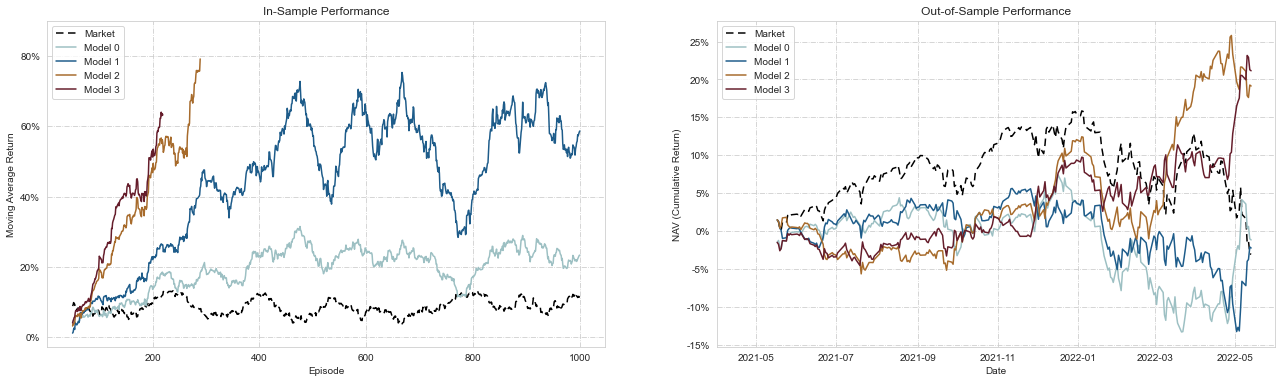

In [7]:
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

axes[0].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[0].plot(train_res_rona_nc.rolling(50).mean(), label = train_res_rona_nc.columns, linewidth=1.5)
axes[0].set_ylim(top = 0.9)
axes[0].lines[0].set_linestyle((0, (5, 3)))
axes[0].legend(loc="upper left")
axes[0].title.set_text("In-Sample Performance")
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Moving Average Return')

axes[1].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[1].plot(test_res_rona_nc, label = test_res_rona_nc.columns, linewidth=1.5)
axes[1].set_xlim(left = datetime.strptime("2021-04-01", '%Y-%m-%d'))
axes[1].lines[0].set_linestyle((0, (5, 3)))
axes[1].legend(loc="upper left")
axes[1].title.set_text('Out-of-Sample Performance')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NAV (Cumulative Return)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Train and Test Result MA(75) with costs anc Rona

In [8]:
# Load Data
train_0_rona_c = pd.read_csv("resu/rona/cost/train_0_c.csv", index_col="Episode")
train_1_rona_c = pd.read_csv("resu/rona/cost/train_1_c.csv", index_col="Episode")
train_2_rona_c = pd.read_csv("resu/rona/cost/train_2_c.csv", index_col="Episode")
train_3_rona_c = pd.read_csv("resu/rona/cost/train_3_c.csv", index_col="Episode")

test_0_rona_c = pd.read_csv("resu/rona/cost/test_0_c.csv", index_col="Date")
test_1_rona_c = pd.read_csv("resu/rona/cost/test_1_c.csv", index_col="Date")
test_2_rona_c = pd.read_csv("resu/rona/cost/test_2_c.csv", index_col="Date")
test_3_rona_c = pd.read_csv("resu/rona/cost/test_3_c.csv", index_col="Date")

# Prepare Data for in-sample and out-of-sample performance
train_res_rona_c = [train_0_rona_c[["Market Ep NAV", "Agent Ep NAV"]], train_1_rona_c[["Agent Ep NAV"]],
                  train_2_rona_c[["Agent Ep NAV"]], train_3_rona_c[["Agent Ep NAV"]]]
train_res_rona_c = pd.concat(train_res_rona_c, axis=1)
train_res_rona_c.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

test_res_rona_c = pd.merge(test_0_rona_c.reset_index()[["Date", "Market NAV", "Agent NAV"]],
                    test_1_rona_c.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_rona_c = pd.merge(test_res_rona_c, test_2_rona_c.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_rona_c = pd.merge(test_res_rona_c, test_3_rona_c.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_rona_c = test_res_rona_c.set_index("Date")
test_res_rona_c.index = pd.to_datetime(test_res_rona_c.index)
test_res_rona_c.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

In [9]:
trading_cost_bps = 1e-4
time_cost_bps = 1e-5

mod_pred = test_0_rona_c[["Market Return"]]
mod_pred[["Action"]] = "X"
mod_pred.columns = ["ret", "act"]

# Get postition of Actions that should be Long or Short
pos = np.where((abs(mod_pred.ret) > (2*trading_cost_bps)).astype(int) == 1)[0]
pos = mod_pred.index[pos]
mod_pred.loc[pos, "act"] = "Y"

# Replace All Y to 2 (Long) or 0 (Short)
def get_action(ret, act):
    if (float(ret) > 0) and (act[0] == "Y"):
        return(2)
    elif (float(ret) < 0) and (act[0] == "Y"):
        return(0)
    else: return("X")

mod_pred.act = mod_pred.apply(lambda x: get_action(x.ret, x.act), axis = 1)

# Handle Neutral Position
for i in range(1, len(mod_pred.index)):
    if (mod_pred.act.iloc[i-1] == 2) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] < 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 2
    elif (mod_pred.act.iloc[i-1] == 0) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 0
    elif (mod_pred.act.iloc[i-1] == 1) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > trading_cost_bps):
            mod_pred.act.iloc[i] = 2
        elif (mod_pred.ret.iloc[i] < (-trading_cost_bps)):
            mod_pred.act.iloc[i] = 0
        else: mod_pred.act.iloc[i] = 1
    else: pass
mod_pred = mod_pred.drop(["ret"], axis = 1)
mod_pred["Market"] = 2

# Create Data Frame with all actions from all Models
df_action = pd.merge(mod_pred, test_0_rona_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_1_rona_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_2_rona_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_3_rona_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = df_action.set_index("Date")
df_action.index = pd.to_datetime(df_action.index)
df_action.columns = ["Target", "Long","Model 0", "Model 1", "Model 2", "Model 3"]
df_action = df_action - 1

# DataFrame with all daily Rewards from Market and ever Model
test_perf_c = pd.merge(test_0_rona_c.reset_index()[["Date", "Market Return", "Agent Return"]],
                     test_1_rona_c.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_c = pd.merge(test_perf_c, test_2_rona_c.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_c = pd.merge(test_perf_c, test_3_rona_c.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_c = test_perf_c.set_index("Date")
test_perf_c.index = pd.to_datetime(test_perf_c.index)
test_perf_c.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

# Get MSE and Accuracy scores
mse_c = []
accuracy_c = []
for i in range(1, len(df_action.columns)):
    mse_c.append(mean_squared_error(df_action.Target, df_action.iloc[:,i]))
    accuracy_c.append(accuracy_score(df_action.Target.tolist(), df_action.iloc[:,i]))

In [10]:
df_train_c = pd.DataFrame({"E(R)": (np.mean(train_res_rona_c)*100).round(2).astype(str) + "%",
                         "std(R)": (np.std(train_res_rona_c)*100).round(2).astype(str) + "%",
                         "Sharpe": (np.mean(train_res_rona_c)/np.std(train_res_rona_c)).round(3)})

df_test_c = pd.DataFrame({"E(R)": (np.mean(test_perf_c)*100*252).round(2).astype(str) + "%",
                        "std(R)":(np.std(test_perf_c)*100*np.sqrt(252)).round(2).astype(str) + "%",
                        "Sharpe": ( ( np.mean(test_perf_c)*252 )/ (np.std(test_perf_c) * np.sqrt(252))  ).round(3),
                        "MSE": np.around(mse_c,3),
                        "Accuracy": np.around(accuracy_c,3)})

In [11]:
df_train_c

,E(R),std(R),Sharpe
Market,9.79%,15.58%,0.628
Model 0,15.19%,19.77%,0.768
Model 1,40.96%,43.82%,0.935
Model 2,29.54%,36.54%,0.809
Model 3,20.9%,30.04%,0.696


In [12]:
df_test_c

,E(R),std(R),Sharpe,MSE,Accuracy
Market,0.55%,17.17%,0.032,1.869,0.524
Model 0,6.87%,16.57%,0.414,1.810,0.452
Model 1,17.68%,17.07%,1.036,1.917,0.488
Model 2,13.69%,16.82%,0.814,1.937,0.468
Model 3,0.6%,15.47%,0.039,1.746,0.421


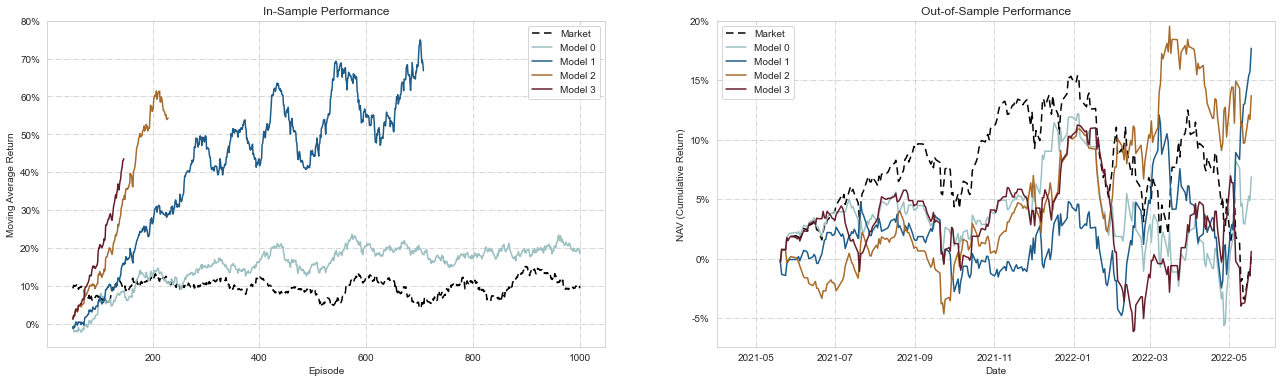

In [13]:
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

axes[0].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[0].plot(train_res_rona_c.rolling(50).mean(), label = train_res_rona_c.columns, linewidth=1.5)
axes[0].set_ylim(top = 0.8)
axes[0].lines[0].set_linestyle((0, (5, 3)))
axes[0].legend(loc="upper right")
axes[0].title.set_text("In-Sample Performance")
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Moving Average Return')

axes[1].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[1].plot(test_res_rona_c, label = test_res_rona_c.columns, linewidth=1.5)
axes[1].set_xlim(left = datetime.strptime("2021-04-01", '%Y-%m-%d'))
axes[1].lines[0].set_linestyle((0, (5, 3)))
axes[1].legend(loc="upper left")
axes[1].title.set_text('Out-of-Sample Performance')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NAV (Cumulative Return)')
axes[1].set_ylim(top = 0.2)

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))